## Treinamento completo de ponta a ponta

### Gerando dados sintéticos

Importando as bibliotecas e criando o reconhecedor alfanumérico.

In [3]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

#assert tf.test.is_gpu_available(), 'No GPU is available.'

data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

Baixando conjuntos de fontes e backgrounds que serão utilizados na geração de uma base de dados sintética.

In [4]:
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for ./fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|██████████| 2746/2746 [00:27<00:00, 101.48it/s]


Looking for ./backgrounds.zip


Criando um gerador de texto.

In [5]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

The first generated text is: Diverse wildlife the object and stores sell


Essa função irá dividir o banco de dados em conjuntos de treinamento, validação e teste.

In [6]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

Dividindo a base de dados de fontes e backgrounds por meio da função criada na célula anterior.

In [7]:
background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

Gerando um conjunto de imagens.

In [8]:
image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

Plotando uma das imagens geradas e seu respectivo texto.

The first generated validation image (below) contains: W
orldwi
de
p
o


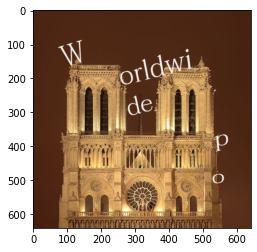

In [31]:
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

### Construindo um modelo básico de detector e reconhecedor

In [9]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


### Treinando o detector

O detector possui um método que converte o gerador de imagens (que retorna imagens com anotações associadas) em um gerador de lotes que retorna pares X,y para o treinamento com o método model.fit(). Infelizmente não foi possível realizar o treinamento pois a base de dados de treinamento é muito grande e isso demandaria mais de 3 mil horas com o meu hardware atual.

In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
    batch_size=detector_batch_size
)

### Treinando o Reconhecedor

O reconhecedor espera que as imagens já estejam recortadas em linhas únicas de texto. Para isso o keras-ocr já possui um método que converte o gerador de imagens em um gerador de imagens de linha única.

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

Como no detector, o reconhecedor também possui um método que converte o gerador de imagens em um gerador de lotes.

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
    image_generator=image_generator,
    batch_size=recognition_batch_size,
    lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=1000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0,
    bacth_size=recognition_batch_size
)

### Utilizando os modelos por inferência

Com o treinamento concluído já podemos utilizá-lo para o reconhecimento de textos.

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions]
)
plt.imshow(drawn)